# **Single Copy Core Gene Replication Slope Analysis**
Author: <br />
Alyse Larkin (larkinsa@uci.edu) <br />
Assistant Project Scientist <br />
Department of Earth System Science <br />
University of California, Irvine 

## Summary
This Jupyter notebook provides the R code necessary to reproduce the analysis described in Larkin *et al.* 2022, *ISME J*, "Basin-scale biogeography of *Prochlorococcus* and SAR11 ecotype replication." Specifically, in this notebook we provide: 
- A function to calculate the terminus of replication using the median circular minimum as first described by Korem *et al.* 2015 
- A function to simultaneously fit forward and reverse linear functions to gene coverage patterns such that the slopes of the forward and reverse (i.e., "right hand" and "left hand") functions are equal 
- An example application of these functions to a marine dataset using the *Prochlorococcus* ecotype HLI 

If users wish to apply this code to their own datasets, users should first obtain: 
- A Sample x Gene matrix containing the coverage values of single cope core genes. We **strongly** recommend that coverage values be based on rarefied reads, such that the same number of reads are used for every sample in the dataset. 
- A single column matrix containing the start locations for every gene based on a reference genome 


## Functions 
Three functions are used to calculate replication slopes. The first function determines the terminus of replication using the circular minimum coverage value across all samples provided. The second function fits left hand and right coverage slopes (lhs = "left hand slope", rhs = "right hand slope") based on coverage values of single copy core genes (SCCGs) as mapped to a reference genome and is used as a starting point for the final function. The third function uses non-linear least squared regression to fit the left hand and right hand linear functions such that the slope of both are the same. 

In [3]:
### Circular Median Minimum Terminus ### 

circularMedian_term <- function(genomeMat){
	
	genomeCov = genomeMat[, colSums(genomeMat) > 0]
	
	Pbar = c()
	for(col in 1:ncol(genomeCov)){
		rowSubMin <- genomeCov[which(genomeCov[, col] > 0), col]
		rowNam <- names(rowSubMin[which.min(rowSubMin)])
		minRow <- which(rownames(genomeCov) == rowNam)
		Pbar = c(Pbar, minRow)
	}
	
	g = nrow(genomeCov)

	tmCalc = c()
	for(t in 1:length(Pbar)){
		val = (Pbar - Pbar[t]) %% g
		tmval = max(val) - min(val)
		tmCalc = c(tmCalc, tmval)
	}
	
	tm = min(tmCalc)
	
	cirMed = (median(c((Pbar - tm) %% g)) + tm) %%  g
	
	return(round(cirMed))
}

### Fit Reverse and Forward (i.e. Left Hand and Right Hand ) Slopes ### 

## Fit Left Hand and Right Hand Linear Fit simultaneously,  different slopes 
twopartfit <- function(x, y){
	f <- function(Cx.open){
		lhs <- function(x) ifelse(x < Cx.open, Cx.open-x, 0)
		rhs <- function(x) ifelse(x < Cx.open, 0, x-Cx.open)
		fit <- lm(y ~ lhs(x) + rhs(x))
		c(summary(fit)$r.squared, summary(fit)$coef[1], summary(fit)$coef[2], summary(fit)$coef[3])
	}
	
	r2 <- function(x) -(f(x)[1])
	
	res <- optimize(r2, interval = c(min(x), max(x)))
	resout <- c(res$minimum, f(res$minimum))
	
	best_Cx <- resout[1]
	coef1 <- resout[3] #Cy
	coef2 <- resout[4] 
	coef3 <- resout[5]
	
	leftHandInt <- coef1 + best_Cx*coef2
	leftHandSl <- -coef2
	rightHandInt <- coef1 - best_Cx*coef3
	rightHandSl <- coef3 
	
	out <- c(leftHandInt, leftHandSl, rightHandInt, rightHandSl)
	print(out)
}


## Fit Left Hand and Right Hand Linear Fit simultaneously, same slopes 
lhrhNLS <- function(x, y, Cx){
	lhs <- function(Cx, A, ya) ifelse(x < Cx, A*(2*Cx - x) + ya, 0)
	rhs <- function(Cx, A, ya) ifelse(x < Cx, 0, A*x + ya)
	nlsfit <- nls(y ~ lhs(Cx, A, ya) + rhs(Cx, A, ya),  data = data.frame(x, y),  start = c(A = twopartfit(x, y)[4], ya = twopartfit(x, y)[3])) ## use differing slopes as the starting point 
	sumfit <- summary(nlsfit)
	A <- sumfit$coef[1] ## slope
	ya <- sumfit$coef[2] ## intercept
	p <- summary(nlsfit)$parameter[1, 4] ## p-value
	pe <- sqrt(mean(summary(nlsfit)$residuals^2))/(max(y) - min(y)) ## Percent Error / Range-Normalized RMSE
	R <- cor(y, predict(nlsfit))^2 ## R^2
	AIC <- AIC(nlsfit) ## AIC value 
	out <- c(A, ya, p, pe, R, AIC)
	print(out)
}

## Example Dataset
In our example dataset, we use the coverage values of 1530 single copy core genes (SCCGs) from the *Prochlorococcus* ecotype HLI using the C13.5 Bio-GO-SHIP transect (Larkin *et al.* 2021). SCCGs were identified using the Anvi'o pangenomic pipeline (Eren *et al.* 2015) and thus use "GC_", or "Gene Cluster", as a naming convention. The gene start locations were determined via the fully sequenced HLI reference genome MED4. 

In [4]:
gene_coverages <- read.csv('HLI_GeneCoverages_C13-5.csv', row.names = 1); gene_coverages

,GC_00000002,GC_00000005,GC_00000007,GC_00000008,GC_00000009,GC_00000010,GC_00000011,GC_00000012,GC_00000013,GC_00000014,⋯,GC_00035808,GC_00035976,GC_00036155,GC_00036405,GC_00036510,GC_00036564,GC_00036567,GC_00037037,GC_00037038,GC_00042629
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C132020_001_META,23.2222222,22.9815171,22.8113294,14.9380555,23.7193703,12.421828910,23.56241830,25.7148362,23.96883469,21.99290780,⋯,3.7073171,14.0206766,4.78582931,9.0593434,8.6517810,8.54361931,14.7214171,5.29629630,5.27766570,11.41226143
C132020_002_META,4.6861728,5.3189530,4.4318051,4.6958518,5.6557153,3.352999017,4.90947712,5.0077071,4.53556911,4.93687943,⋯,1.2899729,2.3943355,1.69243156,2.5189394,2.1919192,2.52837430,2.2560386,1.06441224,1.77603283,2.37398937
C132020_003_META,19.5153086,22.8735897,18.0806618,17.1377262,22.4791239,14.038348080,19.57369281,20.2967245,18.73644986,18.24160757,⋯,4.2845528,11.5032680,6.63285024,10.8219697,7.8176502,10.90019629,10.3659477,7.19323672,8.12055142,12.01425601
C132020_004_META,19.7511111,20.8914744,19.5853154,18.7699163,21.8240931,13.340216320,20.55964052,22.0695247,20.94410569,20.53900709,⋯,6.0930443,10.4945534,4.92431562,9.6830808,11.3540670,8.54270249,11.9873897,5.88888889,8.75645217,10.59716860
C132020_005_META,8.0024691,9.2114957,8.2132598,6.4820736,8.6842345,3.477876106,7.63741830,8.4991972,8.27439024,9.48581560,⋯,1.3947606,1.8562091,0.24315620,3.3282828,2.6549708,1.99675588,2.4847021,1.35104670,2.30002241,3.50693001
C132020_006_META,43.7118519,47.2246154,41.5374009,31.7955919,45.9564225,24.235004920,45.15212418,45.8432884,42.69664634,40.06879433,⋯,8.5121951,21.4610515,9.17069243,20.2328527,16.2982456,17.69524666,21.8100519,10.53623188,15.14716360,25.18679474
C132020_007_META,15.3548148,19.1867308,14.3410318,13.5271440,17.4658909,11.660766960,16.70980392,16.8651252,15.05030488,16.68510638,⋯,2.7037037,7.4466231,3.75362319,7.6287879,6.2328549,8.67302561,10.4182940,5.95330113,5.12880199,7.85100485
C132020_008_META,7.7745679,8.9427350,7.2064805,6.0827334,8.5416381,4.104228122,7.77287582,8.0237636,7.18258808,7.24255319,⋯,1.2032520,3.5076253,1.70209340,2.5911535,2.8564593,2.57907543,1.9790660,3.80354267,2.26381130,3.24745075
C132020_009_META,16.2096296,13.6193376,15.0810065,10.8864086,13.4104495,10.694198620,16.01323529,14.2959216,13.36686992,13.60378251,⋯,1.3586269,3.7734205,2.07085346,4.3761812,1.5279107,4.20924574,7.0852555,2.36231884,2.66792020,3.89880983


In [5]:
genome_order <- read.csv('HLI_GeneOrder.csv', row.names = 1); genome_order

,MED4_Genome_StartPosition
,<int>
GC_00000622,173
GC_00002793,1332
GC_00000054,2043
GC_00000863,4429
GC_00003281,8415
GC_00000431,10366
GC_00004130,11107
GC_00000301,11792
GC_00004453,13182


In the code below we format the gene coverage matrix such that column order matches the gene start locations in the reference genome 

In [7]:
## Match gene coverages to their start location in the reference genome 
gene_start_locations <- as.numeric(genome_order[, 1])

genes_ordered_match <- gene_coverages[, match(rownames(genome_order), colnames(gene_coverages))]
genes_ordered <- genes_ordered_match[order(rownames(genes_ordered_match)), ]

## Check that gene orders are matching
all(rownames(genome_order) == colnames(genes_ordered))


[1] TRUE

## Calculate Terminus 
In the code below we use all samples in our C13.5 dataset to estimate the minimum coverage location of our reference genome and designate that as the terminus of replication. We then re-order our genes based on the terminus location. 


In [8]:
## Calculate Terminus 
terminus <- circularMedian_term(t(genes_ordered))
terminus_start <- gene_start_locations[terminus] 


## Re-order the genes based on the terminus 
new_start_locations <- c() 

for(st in 1:length(gene_start_locations)){
	m <- round(max(gene_start_locations)/2) #middle of array
	if(terminus_start < m){
		d = m - terminus_start #difference between terminus_start and m 
		t = max(gene_start_locations) - d #threshold 
		if(gene_start_locations[st] < t){
			new_start_locations <- c(new_start_locations, gene_start_locations[st] + d)
		} else if(gene_start_locations[st] >= t){
			new_start_locations <- c(new_start_locations, gene_start_locations[st] - t)
		}
		
	} else if(terminus_start > m){
		t = terminus_start - m #threshold
		d = max(gene_start_locations) - t #difference
		if(gene_start_locations[st] < t){
			new_start_locations <- c(new_start_locations, gene_start_locations[st] + d)
		} else if(gene_start_locations[st] >= t){
			new_start_locations <- c(new_start_locations, gene_start_locations[st] - t)
		}
		
	} else {
		new_start_locations <- c(new_start_locations, gene_start_locations[st])
	}
}



## Calculate Slopes
Now that our genes are ordered starting at the origin of replication, through the terminus, and back to the origin, we can calculate the replication slope using the coverage of all SCCGs across our reference genome. 
Note that if all coverage values for a particular sample are 0, then the slope is set to 0. 
If the "lhrhNLS" function does not converge to a single solution, then the slope is reported as "NA." 

In [9]:
## Calculate the slope of coverage,  retain intercepts for plotting purposes  

slopes <- c()
intercepts <- c()

for(s in 1:nrow(genes_ordered)){
	y <- as.numeric(as.character(genes_ordered[s, ]))

	x <- as.numeric(new_start_locations)
	
	Cx <- round(max(new_start_locations)/2)
	
	if(sum(genes_ordered[s, ]) == 0){
		slopes <- c(slopes, 0)
		intercepts <- c(intercepts, 0)
	} else if(class(try(myfit <- lhrhNLS(x, y, Cx))) == "try-error") {
		slopes <- c(slopes, NA)
		intercepts <- c(intercepts, NA)
	} else {
		slopes <- c(slopes, myfit[1])
		intercepts <- c(intercepts, myfit[2])
	}
	
}

slopes_matrix <- matrix(slopes, ncol=1, nrow=length(slopes))
rownames(slopes_matrix) <- rownames(genes_ordered)

intercepts_matrix <- matrix(intercepts, ncol=1, nrow=length(intercepts))
rownames(intercepts_matrix) <- rownames(genes_ordered)


[1]  1.894631e+01 -9.385761e-06  1.298548e+00  1.184571e-05
[1]  1.894631e+01 -9.385761e-06  1.298548e+00  1.184571e-05
[1]  1.060338e-05  2.339213e+00 1.133733e-104  1.337521e-01  2.658539e-01
[6]  8.807261e+03
[1]  3.899152e+00 -5.475867e-07  2.488364e+00  8.288992e-07
[1]  3.899152e+00 -5.475867e-07  2.488364e+00  8.288992e-07
[1] 5.228430e-07 2.969182e+00 2.946402e-05 1.544312e-01 1.136024e-02
[6] 4.876929e+03
[1]  1.636377e+01 -2.813770e-06  8.406351e+00  4.957104e-06
[1]  1.636377e+01 -2.813770e-06  8.406351e+00  4.957104e-06
[1] 3.213297e-06 1.101423e+01 5.062451e-14 1.423016e-01 3.644236e-02
[6] 8.610486e+03
[1]  1.674628e+01 -2.189423e-06  1.024634e+01  4.140981e-06
[1]  1.674628e+01 -2.189423e-06  1.024634e+01  4.140981e-06
[1] 2.413850e-06 1.271930e+01 6.868741e-08 1.479343e-01 1.887131e-02
[6] 8.769623e+03
[1]  5.891973e+00 -1.074559e-06  2.301065e+00  2.432169e-06
[1]  5.891973e+00 -1.074559e-06  2.301065e+00  2.432169e-06
[1] 1.408392e-06 3.687435e+00 2.335494e-11 1.57362

## Check Bi-linear Coverage  
In the code below we examine the first sample in our dataset to ensure that we observe a bi-linear coverage pattern. 

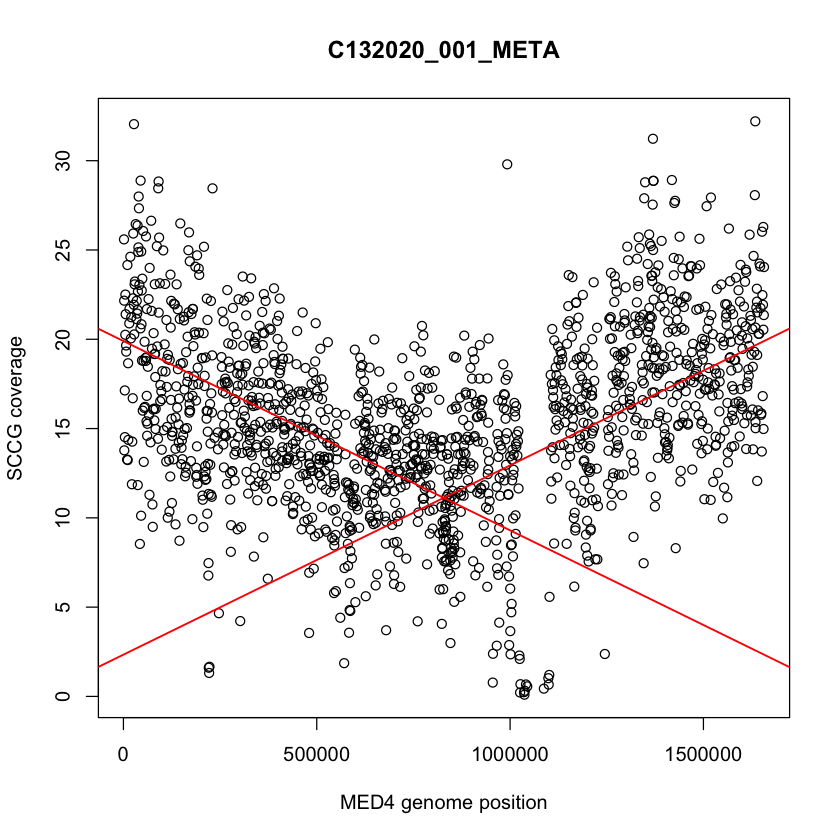

In [10]:
plot(new_start_locations, genes_ordered[1, ], xlab="MED4 genome position", ylab="SCCG coverage", main=toString(rownames(genes_ordered)[1]))
abline(intercepts_matrix[1, ], slopes_matrix[1, ], col='red', lwd=1.5) #rhs
abline(2*slopes_matrix[1, ]*round(max(new_start_locations)/2) + intercepts_matrix[1, ], -slopes_matrix[1, ], col='red', lwd=1.5) #lhs

## Plot Replication 
In the code below we normalize our coverage slopes by multiplying the slope by 1/2 the length of our reference genome. This gives us our replication estimate, R<sub>Obs</sub>. We then plot the first fifty R<sub>Obs</sub> to visualize the variability in replication across the beginning of the C13.5 Bio-GO-SHIP transect. 

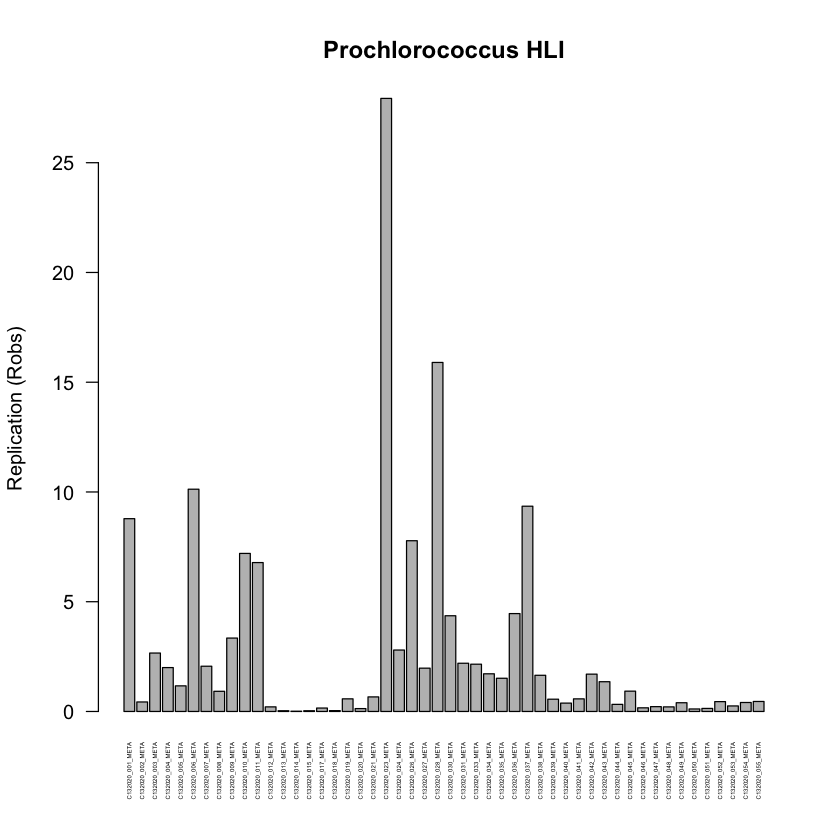

In [11]:
barplot(slopes_matrix[1:50, ] * (max(new_start_locations)/2), horiz=F, beside=T, names.arg=rownames(slopes_matrix[1:50, ]), las=2, cex.names=0.3, ylab="Replication (Robs)", main="Prochlorococcus HLI")